In [3]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.impute import KNNImputer

In [4]:
pd.set_option('display.max_columns', 24)

In [5]:
data = pd.read_csv("data/Dataset_PS2.csv")
data.head(5)

Name  Epoch Date Close Approach Relative Velocity km per sec  \
0  3703080               7.889472e+11                    Very Slow   
1  3723955                        NaN                         Slow   
2  2446862               7.895520e+11                          NaN   
3  3092506               7.901568e+11                    Very Slow   
4  3514799               7.901568e+11                    Very Slow   

   Relative Velocity km per hr  Miles per hour  Miss Dist.(Astronomical)  \
0                 22017.003799    13680.509944                  0.419483   
1                 65210.346095    40519.173105                       NaN   
2                 27326.560182    16979.661798                  0.050956   
3                 40225.948191    24994.839864                       NaN   
4                 35426.991794             NaN                  0.407832   

   Miss Dist.(lunar)  Miss Dist.(kilometers)  Miss Dist.(miles)  \
0         163.178711              62753692.0         38993336.0   
1                NaN              57298148.0         35603420.0   
2          19.821890               7622911.5          4736657.5   
3                NaN                     NaN         26522368.0   
4         158.646713              61010824.0                NaN   

   Jupiter Tisserand Invariant  Epoch Osculation  Semi Major Axis  \
0                          NaN               NaN         1.407011   
1                          NaN         2458000.5         1.107776   
2                        4.557         2458000.5         1.458824   
3                        5.093         2458000.5              NaN   
4                        5.154               NaN         1.225615   

   Asc Node Longitude  Perihelion Arg  Aphelion Dist  Perihelion Time  \
0          314.373913       57.257470       2.005764              NaN   
1          136.717242             NaN       1.497352     2.457795e+06   
2          259.475979      248.415038       1.966857     2.458120e+06   
3           57.173266             NaN       1.527904     2.457902e+06   
4           84.629307      158.263596            NaN     2.457814e+06   

   Mean Anomaly  Mean Motion  approach_year  approach_month  approach_day  \
0    264.837533     0.590551            NaN             1.0           1.0   
1    173.741112     0.845330         1995.0             1.0           1.0   
2           NaN          NaN         1995.0             NaN           8.0   
3     68.741007     0.700277         1995.0             NaN          15.0   
4           NaN          NaN            NaN             NaN          15.0   

  Orbital Period Orbit Uncertainity  Hazardous  
0            Low             Medium       True  
1            Low                NaN      False  
2         Medium                NaN       True  
3            Low             Medium      False  
4            NaN                Low       True

In [6]:
data.apply(pd.isna,axis=0).apply(pd.Series.sum)

Name                               0
Epoch Date Close Approach       1254
Relative Velocity km per sec    1350
Relative Velocity km per hr     1501
Miles per hour                   866
Miss Dist.(Astronomical)         601
Miss Dist.(lunar)               1117
Miss Dist.(kilometers)          1368
Miss Dist.(miles)                652
Jupiter Tisserand Invariant     1732
Epoch Osculation                1527
Semi Major Axis                 1188
Asc Node Longitude              1096
Perihelion Arg                  1134
Aphelion Dist                    815
Perihelion Time                 1564
Mean Anomaly                     918
Mean Motion                     1508
approach_year                    819
approach_month                  1528
approach_day                     543
Orbital Period                   530
Orbit Uncertainity              1767
Hazardous                          0
dtype: int64

In [7]:
cond_check = data.iloc[0]
cond_check = cond_check.fillna("empty")
print(cond_check)
cond_check[cond_check == "empty"].index.map(lambda x: x in ["approach_year","approach_month","approach_day"])

Name                                   3703080
Epoch Date Close Approach       788947200000.0
Relative Velocity km per sec         Very Slow
Relative Velocity km per hr       22017.003799
Miles per hour                    13680.509944
Miss Dist.(Astronomical)              0.419483
Miss Dist.(lunar)                   163.178711
Miss Dist.(kilometers)              62753692.0
Miss Dist.(miles)                   38993336.0
Jupiter Tisserand Invariant              empty
Epoch Osculation                         empty
Semi Major Axis                       1.407011
Asc Node Longitude                  314.373913
Perihelion Arg                        57.25747
Aphelion Dist                         2.005764
Perihelion Time                          empty
Mean Anomaly                        264.837533
Mean Motion                           0.590551
approach_year                            empty
approach_month                             1.0
approach_day                               1.0
Orbital Perio

Index([False, False, False, True], dtype='bool')

In [8]:
def fillApproachDate(data: pd.Series):
    cond_check = data
    cond_check = cond_check.fillna("empty")
    contains_epoch = not cond_check['Epoch Date Close Approach'] == "empty"
    contains_date = not cond_check[cond_check == "empty"].index.map(lambda x: x in ["approach_year","approach_month","approach_day"]).any()
    if(contains_epoch and not contains_date):
        actual_date = datetime.datetime.fromtimestamp(data['Epoch Date Close Approach'] / 1000)
        data.approach_day = actual_date.day
        data.approach_month = actual_date.month
        data.approach_year = actual_date.year
    elif(contains_date and not contains_epoch):
        actual_date = datetime.datetime(int(data.approach_year),int(data.approach_month),int(data.approach_day),0,0,0)
        data['Epoch Date Close Approach'] = int(actual_date.timestamp()) * 1000
    return data

In [9]:
def classifyRelVel(data:pd.Series,very_slow_min, slow_min,fast_min):
    if(pd.isna(data['Relative Velocity km per sec']) and not pd.isna(data['Relative Velocity km per hr'])):
        if(data['Relative Velocity km per hr'] < very_slow_min):
            data['Relative Velocity km per sec'] = "Very Slow"
        elif(data['Relative Velocity km per hr'] < slow_min):
            data['Relative Velocity km per sec'] = "Slow"
        elif(data['Relative Velocity km per hr'] < fast_min):
            data['Relative Velocity km per sec'] = "Fast"
        else:
            data['Relative Velocity km per sec'] = "Very Fast"
    return data


In [10]:
data = data.apply(fillApproachDate,axis=1)
data.head(5)
data['Relative Velocity km per hr'].info()
data['Relative Velocity km per sec'].value_counts()

<class 'pandas.core.series.Series'>
RangeIndex: 4534 entries, 0 to 4533
Series name: Relative Velocity km per hr
Non-Null Count  Dtype  
--------------  -----  
3033 non-null   float64
dtypes: float64(1)
memory usage: 35.6 KB


Relative Velocity km per sec
Slow         1455
Very Slow    1319
Fast          353
Very Fast      57
Name: count, dtype: int64

In [11]:
cat_filt = data.groupby('Relative Velocity km per sec')
very_slow_min = cat_filt.get_group('Very Slow')['Relative Velocity km per hr'].min()
slow_min = cat_filt.get_group('Slow')['Relative Velocity km per hr'].min()
fast_min = cat_filt.get_group('Very Fast')['Relative Velocity km per hr'].min()

In [12]:
data['Relative Velocity km per sec'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4534 entries, 0 to 4533
Series name: Relative Velocity km per sec
Non-Null Count  Dtype 
--------------  ----- 
3184 non-null   object
dtypes: object(1)
memory usage: 35.6+ KB


In [13]:
data = data.apply(lambda x: classifyRelVel(x,very_slow_min,slow_min,fast_min), axis=1)

In [14]:
data['Miss Dist.(Astronomical)'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4534 entries, 0 to 4533
Series name: Miss Dist.(Astronomical)
Non-Null Count  Dtype  
--------------  -----  
3933 non-null   float64
dtypes: float64(1)
memory usage: 35.6 KB


In [15]:
data.iloc[0,0]

np.int64(3703080)

In [16]:
data['Miss Dist.(kilometers)'] = data['Miss Dist.(miles)'] * 1.609344
print(data[data['Miss Dist.(kilometers)'].isna()]['Miss Dist.(lunar)'])
current = data['Miss Dist.(kilometers)'].isna()
data.loc[current, 'Miss Dist.(kilometers)'] = data[current]['Miss Dist.(lunar)'] * 384400
current = data['Miss Dist.(kilometers)'].isna()
data.loc[current,'Miss Dist.(kilometers)'] = data[current]['Miss Dist.(Astronomical)'] * 149597700.02598438
current = data['Miss Dist.(Astronomical)'].isna()
data.loc[current,'Miss Dist.(Astronomical)'] = data[current]['Miss Dist.(kilometers)'] / 149597700.02598438
data['Miss Dist.(Astronomical)'].count()
data = data.drop(columns=['Miss Dist.(kilometers)','Miss Dist.(lunar)','Miss Dist.(miles)'])

4       158.646713
7        50.250694
8              NaN
11      167.665054
22       18.882595
           ...    
4488    173.977036
4493           NaN
4503     98.726303
4524     15.566989
4529           NaN
Name: Miss Dist.(lunar), Length: 652, dtype: float64


In [17]:
data.apply(pd.isna,axis=0).apply(pd.Series.sum)

Name                               0
Epoch Date Close Approach        644
Relative Velocity km per sec     455
Relative Velocity km per hr     1501
Miles per hour                   866
Miss Dist.(Astronomical)          32
Jupiter Tisserand Invariant     1732
Epoch Osculation                1527
Semi Major Axis                 1188
Asc Node Longitude              1096
Perihelion Arg                  1134
Aphelion Dist                    815
Perihelion Time                 1564
Mean Anomaly                     918
Mean Motion                     1508
approach_year                    205
approach_month                   428
approach_day                     163
Orbital Period                   530
Orbit Uncertainity              1767
Hazardous                          0
dtype: int64

In [18]:
data[data['Mean Motion'].notna() & data['Semi Major Axis'].notna()][['Semi Major Axis','Mean Motion']].loc[0]

Semi Major Axis    1.407011
Mean Motion        0.590551
Name: 0, dtype: float64

In [19]:
def fillMeanMotion(data: pd.DataFrame):
    constant_data = data[data['Mean Motion'].notna() & data['Semi Major Axis'].notna()][['Semi Major Axis','Mean Motion']].loc[0]
    constant_mul = constant_data['Mean Motion'] * (constant_data['Semi Major Axis'] ** (3/2))
    data['Mean Motion'] = constant_mul / (data['Semi Major Axis'] ** (3/2))
    return data

In [20]:
data.head(5)

Name  Epoch Date Close Approach Relative Velocity km per sec  \
0  3703080               7.889472e+11                    Very Slow   
1  3723955               7.888986e+11                         Slow   
2  2446862               7.895520e+11                         Slow   
3  3092506               7.901568e+11                    Very Slow   
4  3514799               7.901568e+11                    Very Slow   

   Relative Velocity km per hr  Miles per hour  Miss Dist.(Astronomical)  \
0                 22017.003799    13680.509944                  0.419483   
1                 65210.346095    40519.173105                  0.383015   
2                 27326.560182    16979.661798                  0.050956   
3                 40225.948191    24994.839864                  0.285323   
4                 35426.991794             NaN                  0.407832   

   Jupiter Tisserand Invariant  Epoch Osculation  Semi Major Axis  \
0                          NaN               NaN         1.407011   
1                          NaN         2458000.5         1.107776   
2                        4.557         2458000.5         1.458824   
3                        5.093         2458000.5              NaN   
4                        5.154               NaN         1.225615   

   Asc Node Longitude  Perihelion Arg  Aphelion Dist  Perihelion Time  \
0          314.373913       57.257470       2.005764              NaN   
1          136.717242             NaN       1.497352     2.457795e+06   
2          259.475979      248.415038       1.966857     2.458120e+06   
3           57.173266             NaN       1.527904     2.457902e+06   
4           84.629307      158.263596            NaN     2.457814e+06   

   Mean Anomaly  Mean Motion  approach_year  approach_month  approach_day  \
0    264.837533     0.590551         1995.0             1.0           1.0   
1    173.741112     0.845330         1995.0             1.0           1.0   
2           NaN          NaN         1995.0             1.0           8.0   
3     68.741007     0.700277         1995.0             1.0          15.0   
4           NaN          NaN         1995.0             1.0          15.0   

  Orbital Period Orbit Uncertainity  Hazardous  
0            Low             Medium       True  
1            Low                NaN      False  
2         Medium                NaN       True  
3            Low             Medium      False  
4            NaN                Low       True

<Axes: >

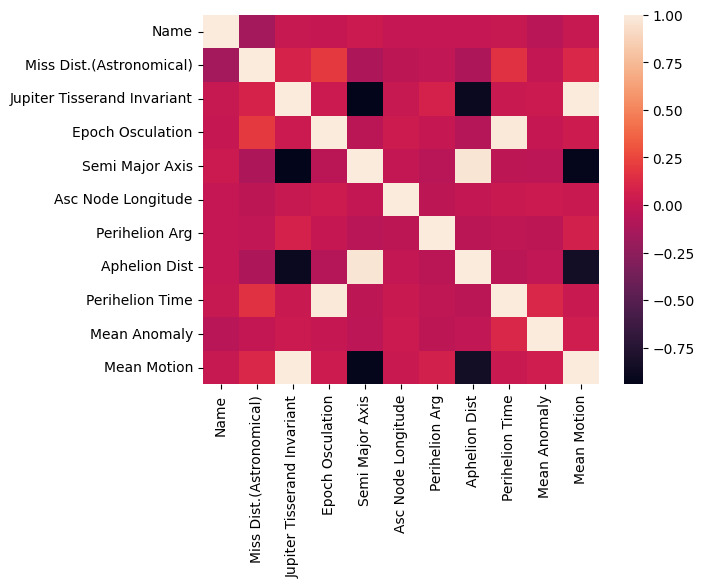

In [21]:
sns.heatmap(data.select_dtypes(exclude=['object','bool']).drop(columns=['Epoch Date Close Approach','Relative Velocity km per hr', 'Miles per hour', 'approach_day','approach_year','approach_month']).corr())

<Axes: xlabel='Mean Motion', ylabel='Jupiter Tisserand Invariant'>

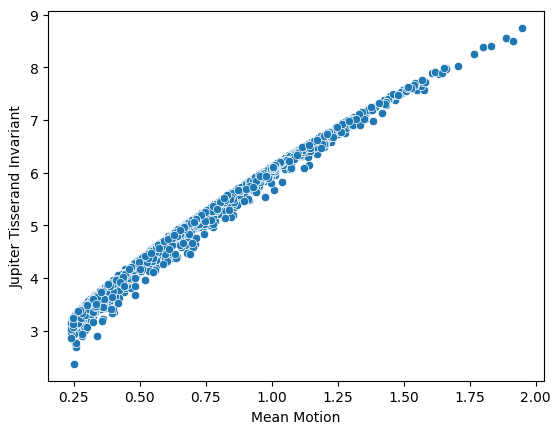

In [22]:
sns.scatterplot(data,x='Mean Motion', y="Jupiter Tisserand Invariant")

In [23]:
new_data = fillMeanMotion(data)
new_data.apply(pd.isna,axis=0).apply(pd.Series.sum)

Name                               0
Epoch Date Close Approach        644
Relative Velocity km per sec     455
Relative Velocity km per hr     1501
Miles per hour                   866
Miss Dist.(Astronomical)          32
Jupiter Tisserand Invariant     1732
Epoch Osculation                1527
Semi Major Axis                 1188
Asc Node Longitude              1096
Perihelion Arg                  1134
Aphelion Dist                    815
Perihelion Time                 1564
Mean Anomaly                     918
Mean Motion                     1188
approach_year                    205
approach_month                   428
approach_day                     163
Orbital Period                   530
Orbit Uncertainity              1767
Hazardous                          0
dtype: int64

<Axes: xlabel='Aphelion Dist', ylabel='Semi Major Axis'>

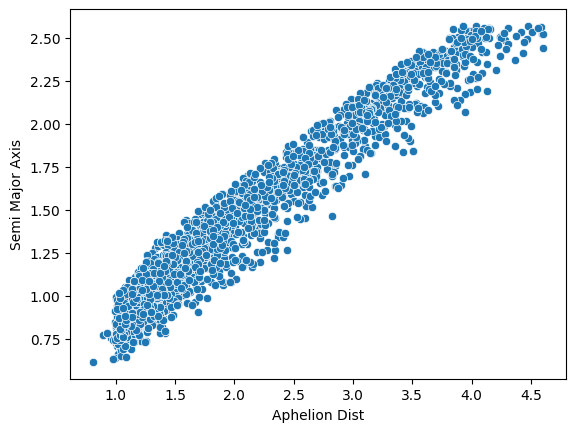

In [24]:
sns.scatterplot(new_data,x='Aphelion Dist', y="Semi Major Axis")


In [25]:
data[['Miles per hour', 'Relative Velocity km per hr']]

Miles per hour  Relative Velocity km per hr
0       13680.509944                 22017.003799
1       40519.173105                 65210.346095
2       16979.661798                 27326.560182
3       24994.839864                 40225.948191
4                NaN                 35426.991794
...              ...                          ...
4529    49556.875548                 79755.354273
4530     7214.337772                 11610.539577
4531    16086.983633                 25889.910626
4532    25393.489071                          NaN
4533    80409.512650                129408.666253

[4534 rows x 2 columns]

In [26]:
data['Relative Velocity km per hr'] = 1.60937011 * data['Miles per hour']

In [27]:
data.apply(pd.isna,axis=0).apply(pd.Series.sum)

Name                               0
Epoch Date Close Approach        644
Relative Velocity km per sec     455
Relative Velocity km per hr      866
Miles per hour                   866
Miss Dist.(Astronomical)          32
Jupiter Tisserand Invariant     1732
Epoch Osculation                1527
Semi Major Axis                 1188
Asc Node Longitude              1096
Perihelion Arg                  1134
Aphelion Dist                    815
Perihelion Time                 1564
Mean Anomaly                     918
Mean Motion                     1188
approach_year                    205
approach_month                   428
approach_day                     163
Orbital Period                   530
Orbit Uncertainity              1767
Hazardous                          0
dtype: int64

In [28]:
data = data.dropna(how="all")
data.info()
data.apply(pd.isna,axis=0).apply(pd.Series.sum)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534 entries, 0 to 4533
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          4534 non-null   int64  
 1   Epoch Date Close Approach     3890 non-null   float64
 2   Relative Velocity km per sec  4079 non-null   object 
 3   Relative Velocity km per hr   3668 non-null   float64
 4   Miles per hour                3668 non-null   float64
 5   Miss Dist.(Astronomical)      4502 non-null   float64
 6   Jupiter Tisserand Invariant   2802 non-null   float64
 7   Epoch Osculation              3007 non-null   float64
 8   Semi Major Axis               3346 non-null   float64
 9   Asc Node Longitude            3438 non-null   float64
 10  Perihelion Arg                3400 non-null   float64
 11  Aphelion Dist                 3719 non-null   float64
 12  Perihelion Time               2970 non-null   float64
 13  Mea

Name                               0
Epoch Date Close Approach        644
Relative Velocity km per sec     455
Relative Velocity km per hr      866
Miles per hour                   866
Miss Dist.(Astronomical)          32
Jupiter Tisserand Invariant     1732
Epoch Osculation                1527
Semi Major Axis                 1188
Asc Node Longitude              1096
Perihelion Arg                  1134
Aphelion Dist                    815
Perihelion Time                 1564
Mean Anomaly                     918
Mean Motion                     1188
approach_year                    205
approach_month                   428
approach_day                     163
Orbital Period                   530
Orbit Uncertainity              1767
Hazardous                          0
dtype: int64

<Axes: xlabel='Orbit Uncertainity', ylabel='count'>

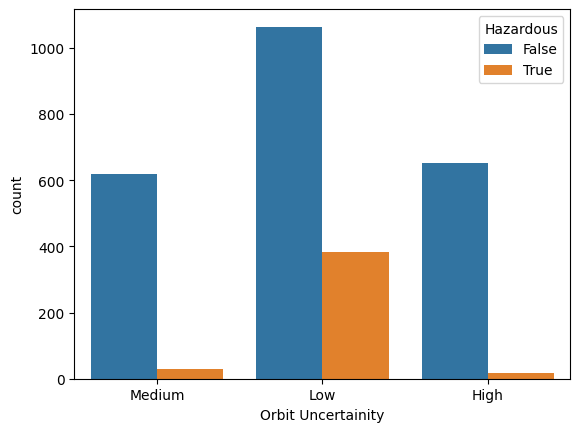

In [36]:
sns.countplot(data,x='Orbit Uncertainity',hue='Hazardous')

<Axes: xlabel='Orbital Period', ylabel='count'>

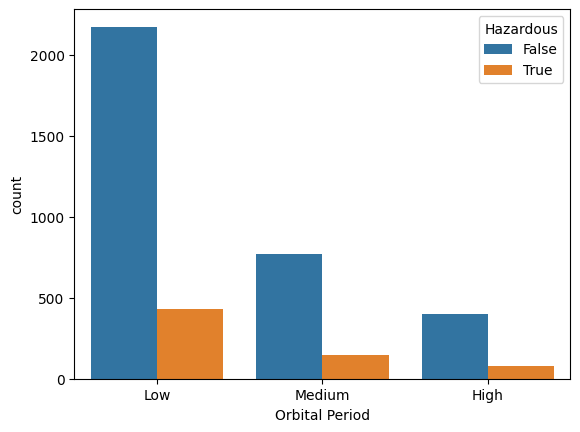

In [37]:
sns.countplot(data,x='Orbital Period',hue='Hazardous')

In [ ]:
data.drop(columns=['approach_year','approach_day','approach_month', 'Miles per hour'],inplace=True)

In [49]:
cat_filt = data.groupby('Relative Velocity km per sec')
very_slow_min = cat_filt.get_group('Very Slow')['Relative Velocity km per hr'].min()
slow_min = cat_filt.get_group('Slow')['Relative Velocity km per hr'].min()
fast_min = cat_filt.get_group('Very Fast')['Relative Velocity km per hr'].min()
data.apply(lambda x: classifyRelVel(x,very_slow_min,slow_min,fast_min),axis=1).apply(pd.isna,axis=0).apply(pd.Series.sum).index

Index(['Name', 'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Semi Major Axis', 'Asc Node Longitude',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion', 'Orbital Period', 'Orbit Uncertainity', 'Hazardous'],
      dtype='object')

In [50]:
data.rename(columns={'Relative Velocity km per sec': 'Relative Velocity Category'}, inplace=True)

In [ ]:
data['Epoch Osculation']

In [ ]:
data['Mean Anomaly'] = data['Mean Motion'] * 

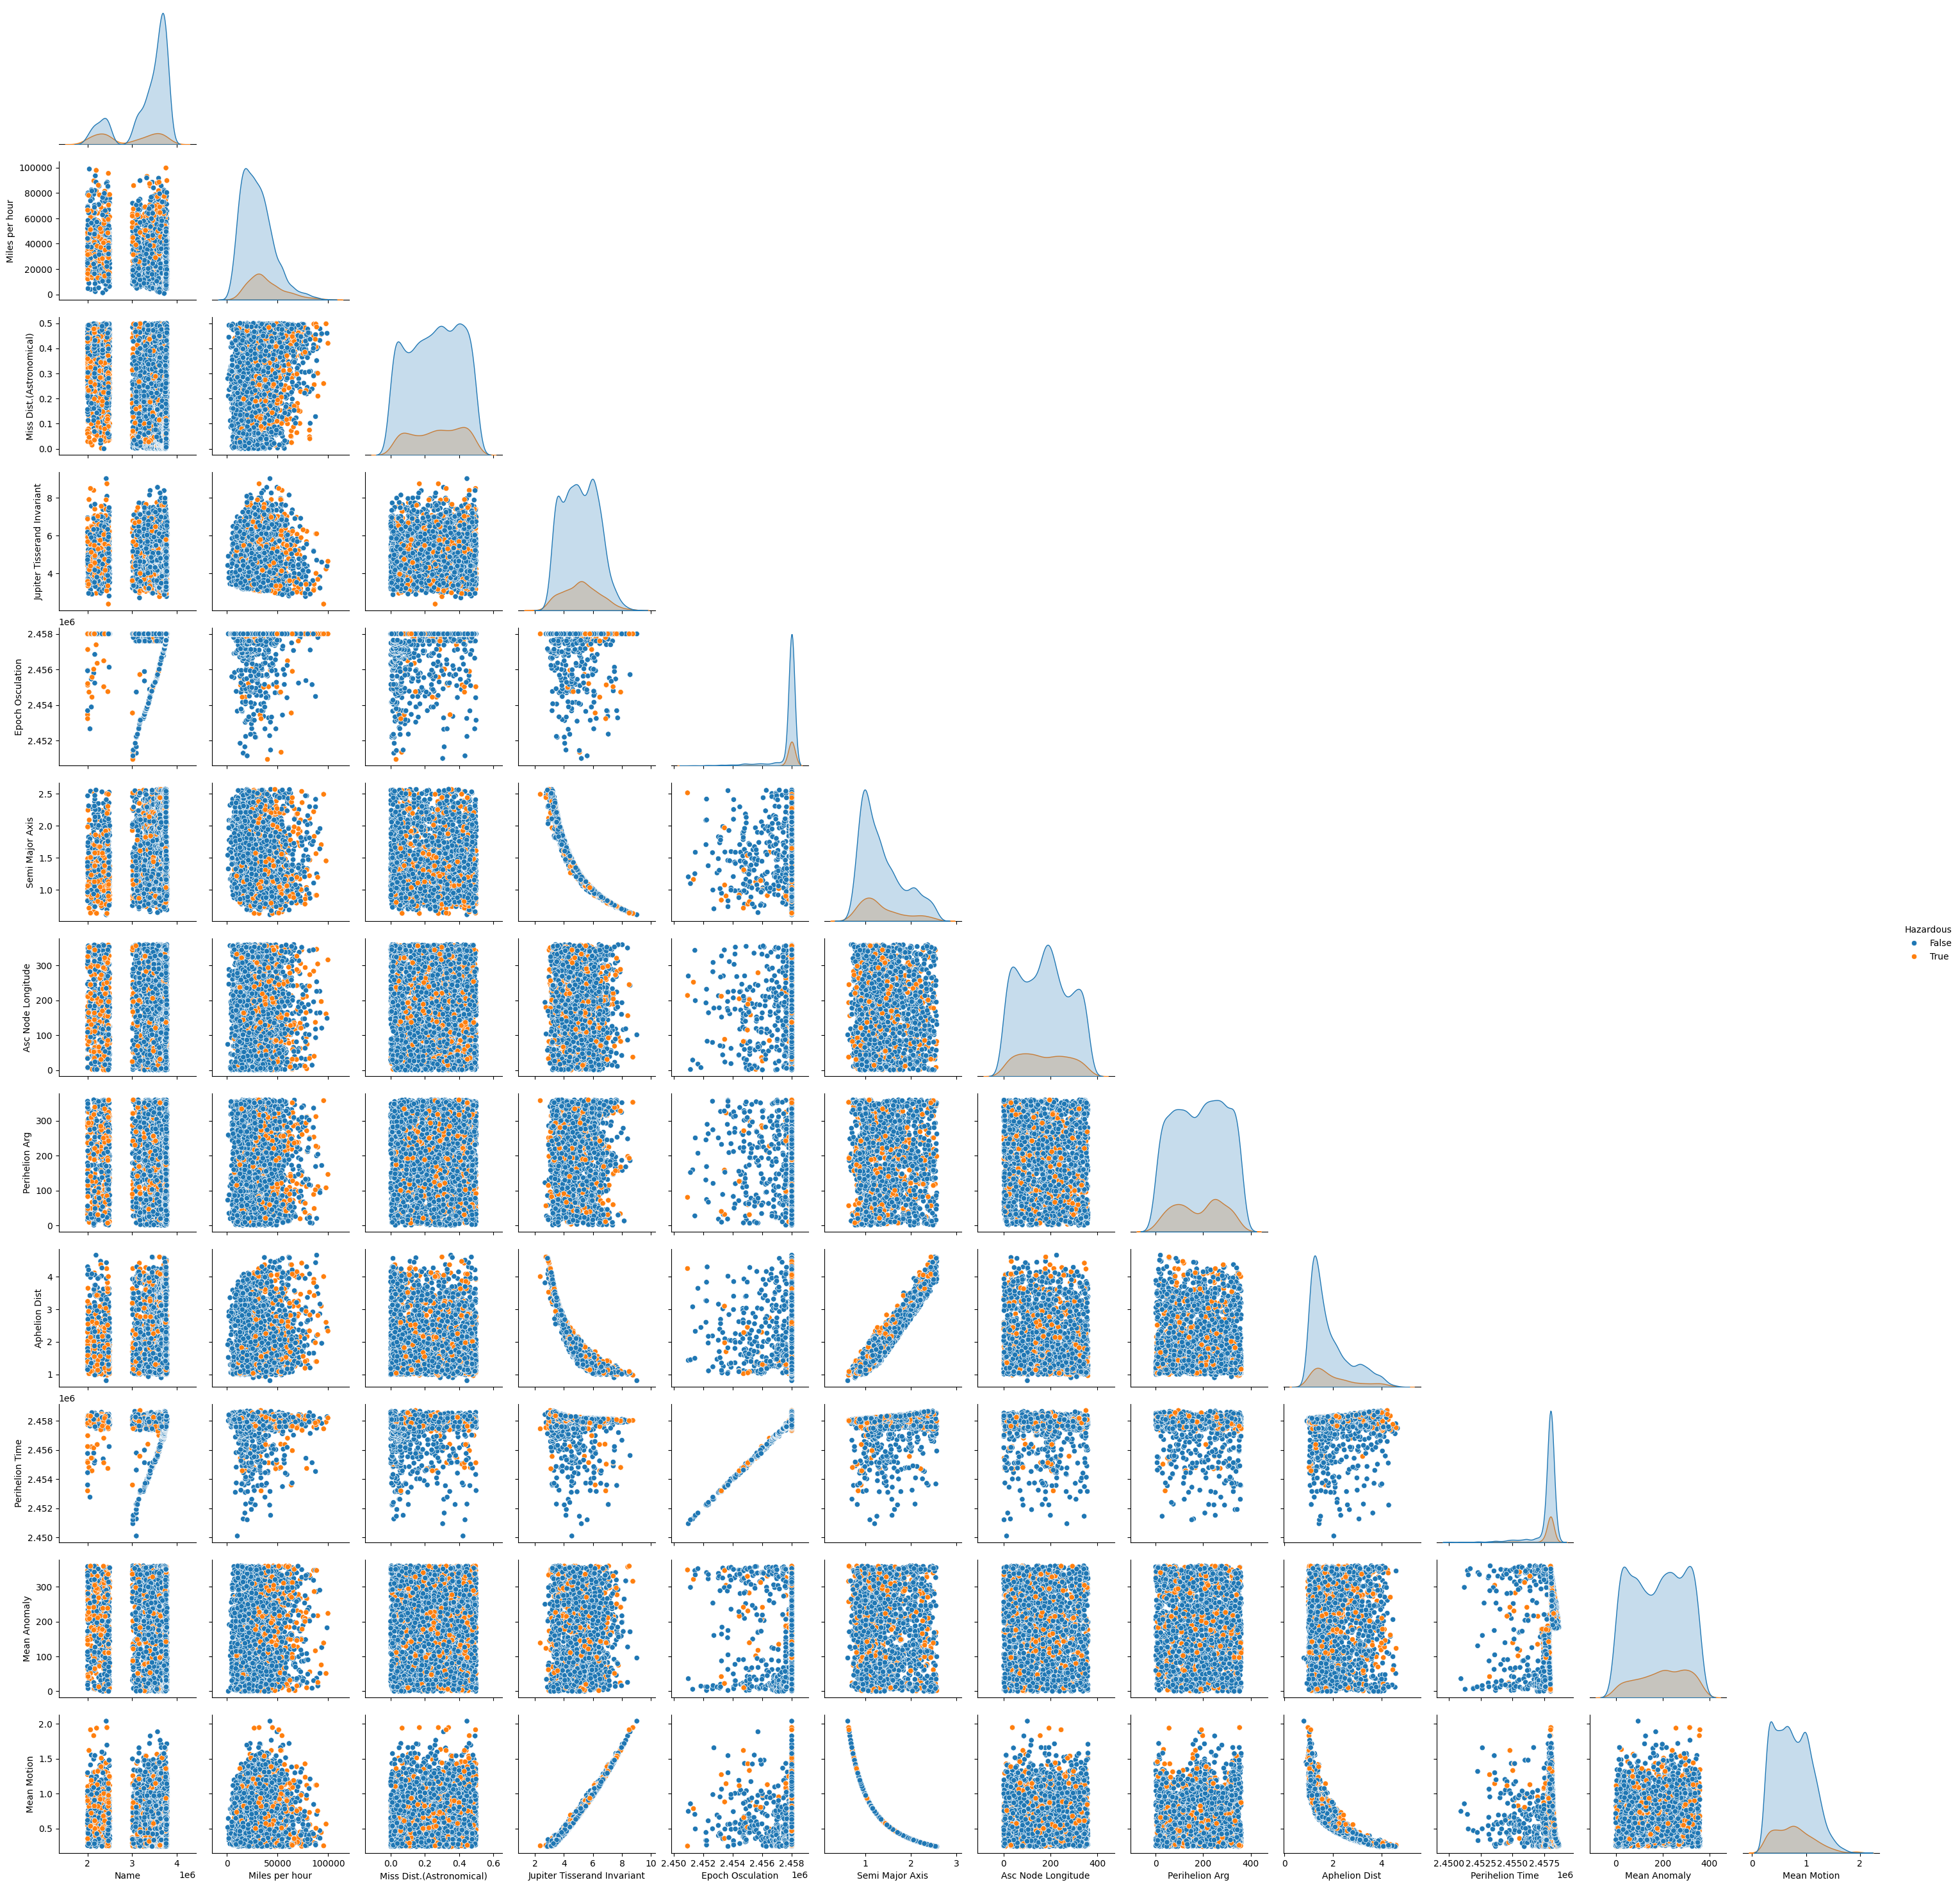

In [ ]:
sns.pairplot(data.drop(columns=['Orbital Period', 'Orbit Uncertainity','Epoch Date Close Approach','Relative Velocity km per hr']), hue='Hazardous' ,corner=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_encoder = OrdinalEncoder(categories=[['Very Slow','Slow','Fast','Very Fast'],['Low','Medium','High'],['Low','Medium','High']])

In [52]:
data['Epoch Osculation'].isna().sum()

np.int64(1527)